In [1]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.style
import scipy.interpolate
import osgeo.osr

import skimage.draw
import skimage.morphology
matplotlib.style.use('ggplot')

%matplotlib inline

In [27]:
# open the netCDF file with velocity fields over time and depth
filename = 'http://opendap-matroos.deltares.nl/thredds/dodsC/maps2d/dcsmv6_zunov4_zuno_kf_hirlam/201606211200.nc'
ds = netCDF4.Dataset(filename)


In [3]:
t = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)
analysis_time = netCDF4.num2date(ds.variables['analysis_time'][:], ds.variables['analysis_time'].units)

In [29]:
sep = ds.variables['sep'][-1]
u1 = ds.variables['velu']
v1 = ds.variables['velv']
lat = ds.variables['lat'][:]
lon = ds.variables['lon'][:]

In [17]:
# coordinate mask (curvilinear grid)
mask = lon.mask
assert (lon.mask == lat.mask).all()

# water levels and velocities are also masked if areas become dry

In [7]:
# let's define the systems
src_srs = osgeo.osr.SpatialReference()
src_srs.ImportFromEPSG(4326)
# google mercator
dst_srs = osgeo.osr.SpatialReference()
dst_srs.ImportFromEPSG(900913)
wgs84 = osgeo.osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
# local UTM
utm = osgeo.osr.SpatialReference()
utm.ImportFromEPSG(32631)

# and the translations between them
src2wgs84 = osgeo.osr.CoordinateTransformation(src_srs, wgs84)
dst2wgs84 = osgeo.osr.CoordinateTransformation(dst_srs, wgs84)
utm2wgs84 = osgeo.osr.CoordinateTransformation(utm, wgs84)
wgs842utm = osgeo.osr.CoordinateTransformation(wgs84, utm)
utm2dst = osgeo.osr.CoordinateTransformation(utm, dst_srs)
src2utm = osgeo.osr.CoordinateTransformation(src_srs, utm)
src2dst = osgeo.osr.CoordinateTransformation(src_srs, dst_srs)

In [12]:
coords_utm = np.array(src2utm.TransformPoints(np.c_[lon.ravel(), lat.ravel()]))
# utm coordinates
# reapply mask
x_utm, y_utm = (
    np.ma.masked_array(coords_utm[:,0].reshape(lon.shape), mask=mask), 
    np.ma.masked_array(coords_utm[:,1].reshape(lat.shape), mask=mask)
    )


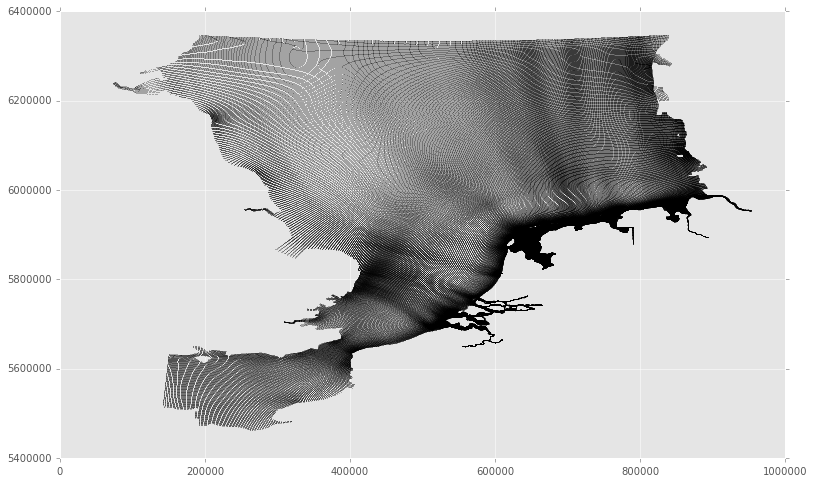

In [13]:
fig, ax = plt.subplots(figsize=(13,8))
ax.plot(x_utm.ravel(), y_utm.ravel(), 'k.', alpha=0.3, markersize = 1 )

In [18]:
# compute cell edges (curvlinear grid plot)

# compute gradients in X and Y
Xx, Xy = np.gradient(x_utm)
Yx, Yy = np.gradient(y_utm)

# lower left
ll = np.c_[(x_utm - 0.5*Xx + 0.5*Yx)[~mask], (y_utm - 0.5*Yy + 0.5*Xy)[~mask]]
# lower right
lr = np.c_[(x_utm + 0.5*Xx + 0.5*Yx)[~mask], (y_utm - 0.5*Yy - 0.5*Xy)[~mask]]
# upper left
ul = np.c_[(x_utm - 0.5*Xx - 0.5*Yx)[~mask], (y_utm + 0.5*Yy + 0.5*Xy)[~mask]]
# upper right
ur = np.c_[(x_utm + 0.5*Xx - 0.5*Yx)[~mask], (y_utm + 0.5*Yy - 0.5*Xy)[~mask]]

verts = np.hstack(
    [
        ll[:,np.newaxis,:], 
        lr[:,np.newaxis,:], 
        ur[:,np.newaxis,:], 
        ul[:,np.newaxis,:]
    ]
)



In [19]:
# pre-compute polygons for faster plotting
poly = matplotlib.collections.PolyCollection(
    np.hstack([ll[:,np.newaxis,:], lr[:,np.newaxis,:], ur[:,np.newaxis,:], ul[:,np.newaxis,:]]),
    edgecolors='none'
)

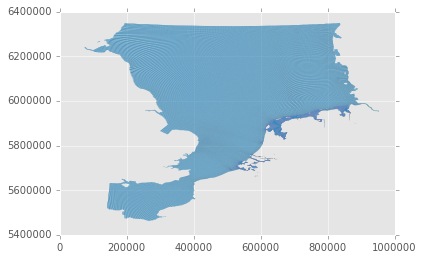

In [20]:
# check if we have a map
fig, ax = plt.subplots()
ax.add_collection(poly)
ax.autoscale()

In [21]:
# We want velocities in pixels/s in our target coordinate system

# We thus need to know how wide each pixel is in the  target system

# We also have to take into account that 1 meter in utm10n does not correspond to 
# 1 meter in web mercator. 
# The web mercator is not very accurate, it is not a conformal projection.

# One way to correct for this is to compute a correction factor for each point

points_gm = np.array(utm2dst.TransformPoints(np.c_[x_utm.ravel(), y_utm.ravel()]))
points_utm = np.array(np.c_[x_utm.ravel(), y_utm.ravel(), np.zeros_like(x_utm.ravel())])

# compute the local distortion 
# how many meters is 1 meter in the projected system, given x,y
x_plus_half = np.array(utm2dst.TransformPoints(np.c_[x_utm.ravel() + 0.5, y_utm.ravel()]))
x_minus_half = np.array(utm2dst.TransformPoints(np.c_[x_utm.ravel() - 0.5, y_utm.ravel()]))
y_plus_half = np.array(utm2dst.TransformPoints(np.c_[x_utm.ravel(), y_utm.ravel() + 0.5]))
y_minus_half = np.array(utm2dst.TransformPoints(np.c_[x_utm.ravel(), y_utm.ravel() - 0.5]))

# compute the deformation factor
x_distort = (x_plus_half - x_minus_half)[:,0]
y_distort = (y_plus_half - y_minus_half)[:,1]

/Users/baart_f/.virtualenvs/main/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in subtract
/Users/baart_f/.virtualenvs/main/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in subtract


In [22]:
points_gm_central = (points_gm[~mask.ravel()] - (points_gm[~mask.ravel()]).mean(axis=0))
points_utm_central = points_utm[~mask.ravel()] - (points_utm[~mask.ravel()]).mean(axis=0)
points_gm_central[:,0].shape

(401366,)

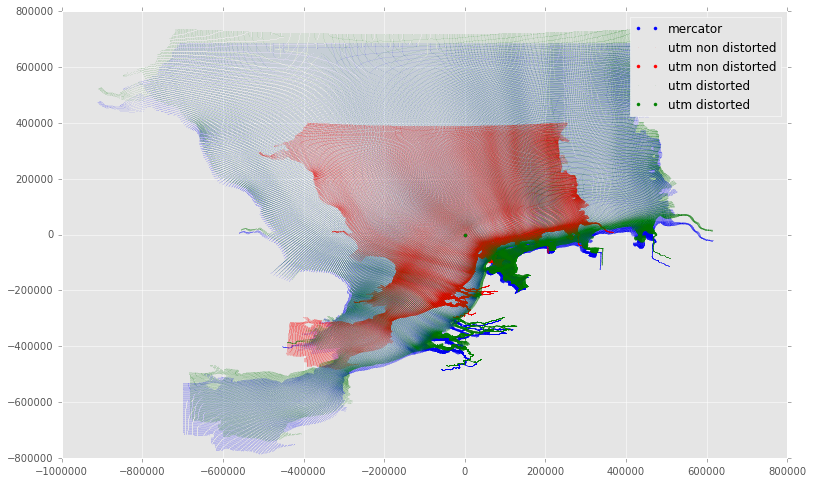

In [23]:
# check if these velocities match up, somewhat...
# See http://www.hydrometronics.com/downloads/Web%20Mercator%20-%20Non-Conformal,%20Non-Mercator%20(notes).pdf
# for details
fig, ax = plt.subplots(figsize=(13,8))
ax.plot(points_gm_central[:,0], points_gm_central[:,1], 'b.', alpha=0.4, markersize=0.2)
ax.plot(0,0, 'b.', label='mercator')
ax.plot(points_utm_central[:,0] , points_utm_central[:,1] , 'r.', label='utm non distorted', alpha=0.4, markersize=0.2)
ax.plot(0,0, 'r.', label='utm non distorted')
ax.plot(points_utm_central[:,0] * x_distort[~mask.ravel()], points_utm_central[:,1] * y_distort[~mask.ravel()], 'g.', label='utm distorted', alpha=0.4, markersize=0.2)
ax.plot(0,0, 'g.', label='utm distorted')
ax.legend()

In [24]:
points_gm.shape, u1.shape, x_distort.shape

((924462, 3), (638, 1449), (924462,))

In [43]:
# create an interpolation function that gives us velocities at each point in the domain.
# in this case we use a triangulated interpolation, which isn't optimal, but ok for now

# Create an interpolation function to map the velocities in web mercator projection
F = scipy.interpolate.LinearNDInterpolator(
    points_gm[~mask.ravel(),:2], 
    np.c_[
        u1[-1].filled(0).ravel()[~mask.ravel()] * x_distort[~mask.ravel()], 
        v1[-1].filled(0).ravel()[~mask.ravel()] * y_distort[~mask.ravel()]
    ]
)
F.fill_value = 0.0

In [44]:
# now create a map in google mercator
ll_gm = [F.points[:,0].min(), F.points[:,1].min()]
ur_gm = [F.points[:,0].max(), F.points[:,1].max()]

# we want a big map as the base layer. 
nx = 1024
ny = 1024

x_gm = np.linspace(ll_gm[0], ur_gm[0], num=nx)
y_gm = np.linspace(ll_gm[1], ur_gm[1], num=ny)

X, Y = np.meshgrid(x_gm, y_gm)

In [45]:
UV = F(X, Y)

ll_wgs84 = dst2wgs84.TransformPoint(x_gm[0], y_gm[0])
ur_wgs84 = dst2wgs84.TransformPoint(x_gm[-1], y_gm[-1])
# this is the bounding box that we need for adding the map
# should this be plus 1 cell?
ll_wgs84, ur_wgs84


((-3.8773453042100003, 49.26419830310948, 0.0),
 (9.84266756344007, 57.16299438380172, 0.0))

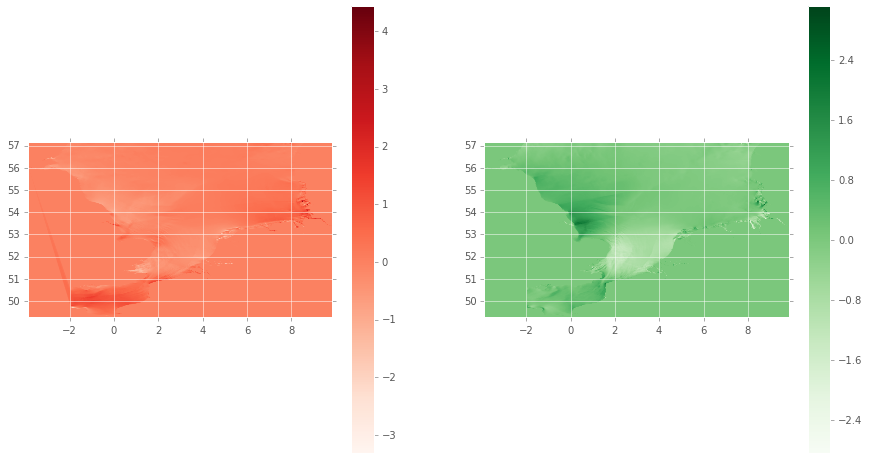

In [56]:
fig, axes = plt.subplots(1,2 , figsize=(15,8))
im = axes[0].imshow(UV[...,0], cmap='Reds', origin='lower', extent=[ll_wgs84[0], ur_wgs84[0], ll_wgs84[1], ur_wgs84[1] ])
plt.colorbar(im, ax=axes[0])
im = axes[1].imshow(UV[...,1], cmap='Greens', origin='lower', extent=[ll_wgs84[0], ur_wgs84[0], ll_wgs84[1], ur_wgs84[1] ])
plt.colorbar(im, ax=axes[1])

In [57]:
verts_gm = np.array(
    utm2dst.TransformPoints(
        np.c_[
            verts[...,0].ravel(), 
            verts[...,1].ravel()
        ]
    )
)[:,:2].reshape(verts.shape)

In [58]:
verts_px = np.zeros_like(verts_gm)
verts_px[...,0] = nx*(verts_gm[...,0] - ll_gm[0])/(ur_gm[0] - ll_gm[0])
verts_px[...,1] = ny*(verts_gm[...,1] - ll_gm[1])/(ur_gm[1] - ll_gm[1])

In [60]:
# isgrid should also compute if_wet
isgrid = np.zeros((ny, nx), dtype='bool')
for contour in verts_px:
    rr, cc = skimage.draw.polygon(contour[:,1], contour[:,0], isgrid.shape)
    isgrid[rr, cc] = True
# want to dilate the grid a bit so colors will run through
isgrid = ~skimage.morphology.dilation(isgrid, skimage.morphology.square(5))


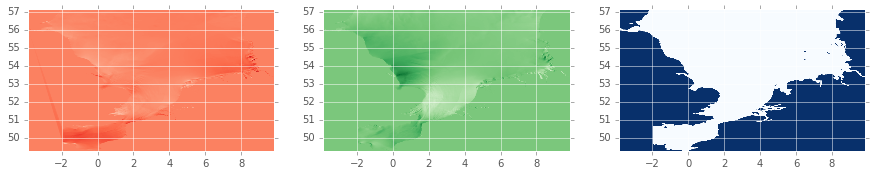

In [61]:
extent=[ll_wgs84[0], ur_wgs84[0], ll_wgs84[1], ur_wgs84[1] ]
fig, axes = plt.subplots(1, 3 , figsize=(15,8))
axes[0].imshow(UV[...,0], cmap='Reds', origin='lower', extent=extent)
axes[1].imshow(UV[...,1], cmap='Greens', origin='lower', extent=extent)
axes[2].imshow(isgrid, cmap='Blues', origin='lower', extent=extent)

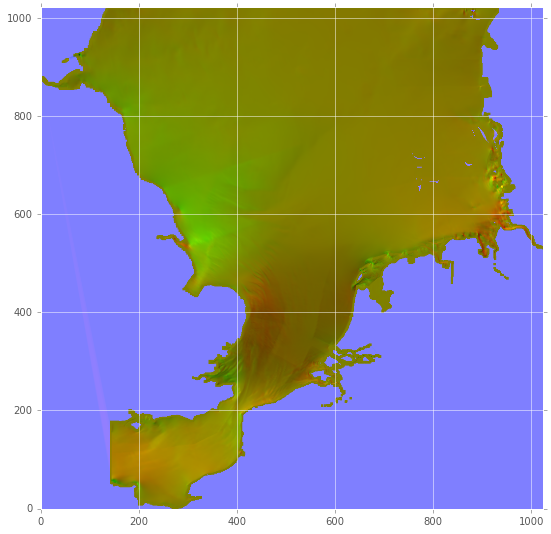

In [62]:
N_uv = matplotlib.colors.Normalize(-3, 3, clip=True)
r = N_uv(UV[...,0]).filled(0)
g = N_uv(UV[...,1]).filled(0)
b = isgrid
rgb = np.dstack([r,g,b])
plt.imsave('test.png', rgb)
plt.figure(figsize=(13,9))
plt.imshow(rgb, origin='top')


In [ ]:

# TODO, generate img, fix masks ...
import itertools
count = itertools.count()
framescale = 30.0
for t in range(0, 12):
    for i in range(int(framescale)):
        u0_top = ds.variables['U1'][t, 0]
        v0_top = ds.variables['V1'][t, 0]
        u1_top = ds.variables['U1'][t+1, 0]
        v1_top = ds.variables['V1'][t+1, 0]
        # interpolate u,v
        # todo: implement optical flow interpolation, like 
        # https://github.com/slowmoVideo/slowmoVideo
        u_top = (1.0 - (i/framescale)) * u0_top + (i/framescale) * u1_top
        v_top = (1.0 - (i/framescale)) * v0_top + (i/framescale) * v1_top
        
        kfu = ds.variables['KFU'][t]
        kfv = ds.variables['KFV'][t]
        mask = ~np.logical_or(kfu, kfv)
        # compute the corrected velocities
        uv = np.c_[
            u_top.ravel()[~mask.ravel()] * x_distort[~mask.ravel()], 
            v_top.ravel()[~mask.ravel()] * y_distort[~mask.ravel()]
        ]
        # Create an interpolation function to map the velocities in web mercator projection
        F = scipy.interpolate.LinearNDInterpolator(
            points_gm[~mask.ravel(),:2], 
            uv
        )
        F.fill_value = 0.0
        UV = F(X, Y)
        r = N_uv(UV[...,0]).filled(0)
        g = N_uv(UV[...,1]).filled(0)
        b = isgrid
        rgb = np.dstack([r,g,b])
        plt.imsave('vec_%04d.png' % (next(count),), rgb)


In [86]:
isgrid.shape, mask.shape

((1024, 1024), (820, 486))

In [ ]:
skimage.